In [0]:
!ls

sample_data


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!unzip  ./drive/'My Drive'/'Colab Notebooks'/masha/bl.zip -d ..

Streaming output truncated to the last 5000 lines.
  inflating: ../results/example/00000107_pred_mask.png  
  inflating: ../results/example/00000067_img.jpg  
  inflating: ../results/example/00000114_crop.png  
  inflating: ../results/example/00000115_crop.png  
  inflating: ../results/example/00000077_img.jpg  
  inflating: ../results/example/00000005_img.jpg  
  inflating: ../results/example/00000055_crop.png  
  inflating: ../results/example/00000015_img.jpg  
  inflating: ../results/example/00000054_crop.png  
  inflating: ../results/example/00000194_pred_mask.png  
  inflating: ../results/example/00000079_pred_mask.png  
  inflating: ../results/example/00000129_pred_mask.png  
  inflating: ../results/example/00000183_pred_mask.png  
  inflating: ../results/example/00000188_img.jpg  
  inflating: ../results/example/00000117_pred_mask.png  
  inflating: ../results/example/00000047_pred_mask.png  
  inflating: ../results/example/00000198_img.jpg  
  inflating: ../results/example/0000

In [0]:
import os
os.chdir("..")

import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from glob import glob

from lib import *

%matplotlib inline

In [4]:
! ls ..

bin					   lib32      run
boot					   lib64      sbin
content					   __MACOSX   srv
data					   media      swift
datalab					   mnt	      sys
dev					   notebooks  tensorflow-2.1.0
dlib-19.18.0-cp27-cp27mu-linux_x86_64.whl  opt	      tmp
dlib-19.18.0-cp36-cp36m-linux_x86_64.whl   proc       tools
etc					   README.md  usr
home					   results    var
lib					   root


In [0]:
# !unzip  ./drive/'My Drive'/'Colab Notebooks'/masha/bl.zip -d ..

# Задача

**Требуется:** предложить модель, сегментирующую человека на фотографии.  
  
**Вход:** фотография 320x240x3.  
**Выход:** маска человека 320x240.  
**Метрика:** [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient).  
  
  
Данные представляют из себя набор фотографий человека и маски, определяющей положение человека на фотографии.  
Доступные данные разделены на несколько папок:  
- `train` содержит фотографии 320x240x3;
- `train_mask` содержит маски для фотографий из `train` 320x240;
- `valid` содержит фотографии 320x240x3;
- `valid_mask` содержит маски для фотографий из `valid` 320x240;
- `test` содержит фотографии 320x240x3.  
  
Для лучшей модели требуется создать 2 файла, которые необходимы для валидации Вашего решения:  
- сохраненные значения метрик на `val` в формате `pred_val_template.csv`;
- html страницу с предсказанием модели для всех картинок из `real_test` и папку с используемыми картинками в этой html странице.  
  
Также необходимо:
- подготовить код для проверки (докстринги, PEP8);
- создать отчет (можно прямо в ноутбуке) с описанием Вашего исследования, гипотез, анализ данных и т.п.

Примеры приведены ниже.

---

# Данные, метрики и доступные функции

Посмотрим на данные:

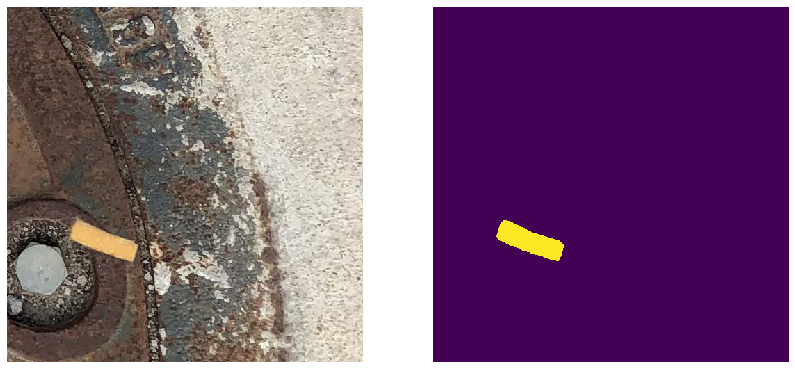

In [6]:
path = "data/train"
images = os.listdir(f"{path}/images")
annotations = json.load(open(f"{path}/coco_annotations.json", "r"))
img_id = int(np.random.choice(images).split(".")[0])

img = np.array(Image.open(f"{path}/images/{img_id:08}.jpg"))
mask = get_mask(img_id, annotations)
show_img_with_mask(img, mask)

Пример подсчета метрики:

In [7]:
random_mask = np.random.randint(low=0, high=2, size=mask.shape)
get_dice(mask, random_mask)

0.021411134088347043

Можно для последовательности масок вычислить среднее значение метрики:

In [8]:
random_masks_1 = [np.random.randint(low=0, high=2, size=mask.shape) for i in range(10)]
random_masks_2 = [np.random.randint(low=0, high=2, size=mask.shape) for i in range(10)]
get_dice(random_masks_1, random_masks_2)

0.5000398322103986

Пример использования функций `encode_rle` и `decode_rle`:
1. Функция `encode_rle` используется для кодирования маски в строку для последующей записи в файл;
2. Функция `decode_rle` используется для восстановления маски по закодированной строке.

In [9]:
rle_mask = encode_rle(mask)
rle_mask

'157798 5 158309 11 158820 14 159331 17 159843 19 160354 22 160865 25 161377 27 161888 30 162400 32 162912 34 163424 36 163935 39 164447 41 164959 43 165470 46 165982 48 166494 50 167005 53 167517 57 168029 60 168541 64 169052 68 169564 72 170077 74 170590 76 171102 80 171615 82 172128 85 172642 85 173156 84 173670 83 174184 82 174698 81 175212 80 175726 79 176240 77 176757 72 177272 69 177786 67 178300 64 178814 62 179327 61 179841 59 180355 56 180872 51 181388 47 181901 45 182416 42 182932 38 183448 34 183964 29 184479 26 184993 23 185508 20 186023 16 186537 14 187052 10 187570 4'

Теперь восстановим маску:

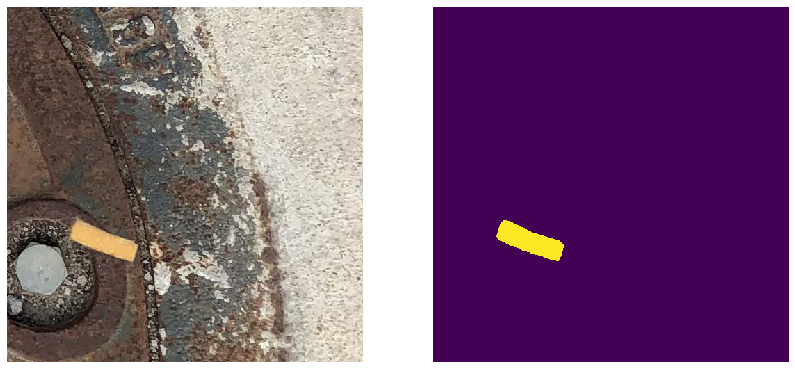

In [10]:
decoded_mask = decode_rle(rle_mask)
show_img_with_mask(img, decoded_mask)

---

# Результаты

Пример файла для изображений из `data/valid`:  
_Каждую предсказанную маску для изображения из `valid` необходимо закодировать и записать в показанный ниже файл, который служит примером, именно в таком виде нужно будет представить результат Вашего лучшего решения на данных из `valid`._

In [11]:
pred = pd.read_csv("data/pred_val_template.csv")
pred.head()

img_id                                           rle_mask
0       0  171654 1 172158 1 172164 5 172670 3 172674 12 ...
1       1  171654 1 172158 1 172164 5 172670 3 172674 12 ...
2       2  171654 1 172158 1 172164 5 172670 3 172674 12 ...
3       3  171654 1 172158 1 172164 5 172670 3 172674 12 ...
4       4  171654 1 172158 1 172164 5 172670 3 172674 12 ...

Для данных из `test` требуется создать html страницу + картинки для нее.  
Это можно сделать с помощью функции `get_html`, как показано ниже.

In [0]:
val_annotations = json.load(open(f"data/val/coco_annotations.json", "r"))
paths_to_imgs = sorted(glob("data/val/images/*"))
img_ids = [int(path.split("/")[-1].split(".")[0]) for path in paths_to_imgs]
pred_masks = [get_mask(img_id, val_annotations) for img_id in sorted(img_ids)]

_ = get_html(paths_to_imgs, pred_masks, path_to_save="results/example")

В папке `results` создался файл `example.html` и папка `examples` с используемыми картинками.

#  Попробуем стандартную модель  сегментации

In [13]:
!pip install segmentation_models.pytorch
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

     |████████████████████████████████| 51kB 4.0MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.1-cp36-none-any.whl size=12410 sha256=912c341c9e685f7ecb187cd65ae43a11711c75dc232f3de89474e44ba64b2ad3
  Stored in directory: /root/.cache/pip/wheels/0f/b0/79/1663bc9714b5d88deba05e44f593ce50111bd69305a45df87a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=b74cd2bf811ed1cd5460fadd7b01525f7cca08968dea9e49ab9137f626db9e5b
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-2jmu_iwf
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-2jmu_iwf
     |████████████████████████████████| 634kB 9.2MB/s 
  Created wheel for albumentations: fi

In [0]:

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [0]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torchvision import transforms, datasets, models
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [0]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    """
    def __init__(
            self, 
            images_dir, 
            masks_dir=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.train = True if masks_dir else False
        self.images = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.images]
        self.ids = list(map(lambda x: int(x.split('.')[0]),os.listdir(images_dir)))
        if self.train:
            self.annotations = json.load(open(masks_dir, "r"))
            self.masks_fps = list(map(lambda x: get_mask(x, annotations),self.ids))
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = np.zeros(image.shape)
        if self.train :
            mask = self.masks_fps[i]  
        # apply augmentations
        if self.augmentation and self.train:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        # apply preprocessing
        image_train = None
        if self.preprocessing:
            image_train = self.preprocessing(image)
            
        mask = torch.Tensor(mask)
        # image = torch.Tensor(image)
        if self.preprocessing:
            return image_train, mask if self.train == True else image
        else:
          return image , mask if self.train == True else image
                                                                    
        
    def __len__(self):
        return len(self.ids)

In [0]:
# функция для визуализации
def visualize(normalize=True, **images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if normalize:
          plt.imshow(image/255)
        else:
          plt.imshow(image)
    plt.show()

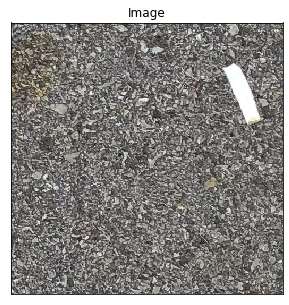

In [18]:
#  Тест
dataset = Dataset(f"{path}/images")
image,_ = dataset[99] 
visualize(
    image=image, 
)

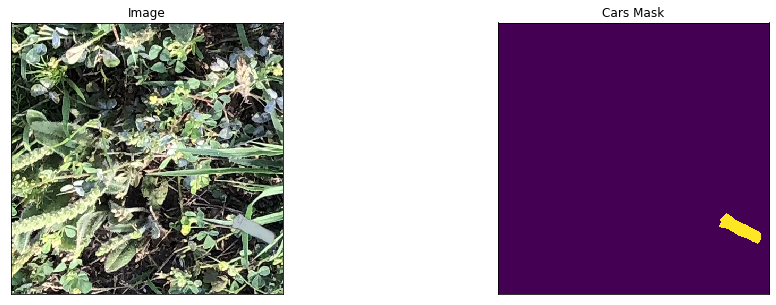

In [19]:
# Нарисум графики с маской 
path = "data/train"
dataset = Dataset(f"{path}/images", f"{path}/coco_annotations.json")
image, mask = dataset[1] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

In [0]:
# Добавим разные аугментации
import albumentations as albu
def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.3, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.IAAAdditiveGaussianNoise(p=0.3),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing():
    """Construct preprocessing transform
    Return:
        transform: albumentations.Compose
    
    """
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), # imagenet
       
    ])

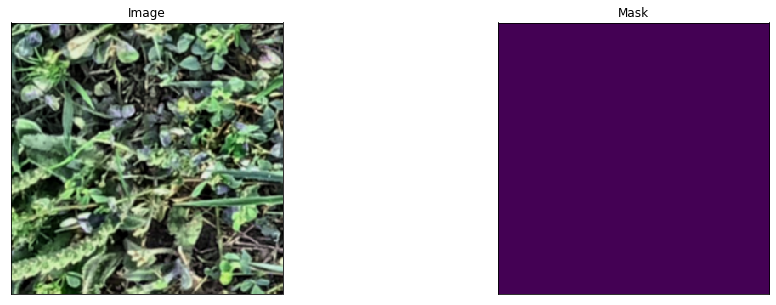

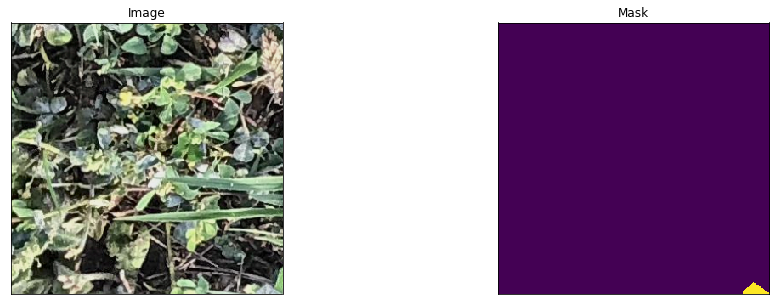

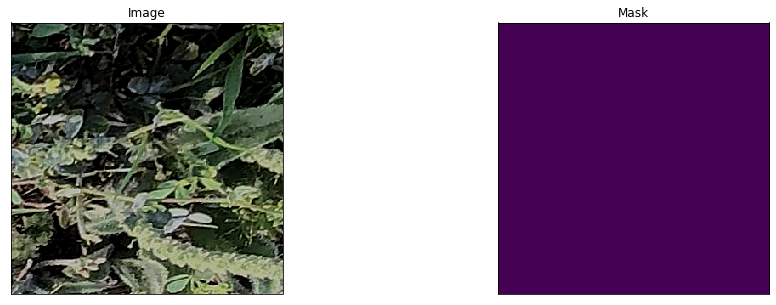

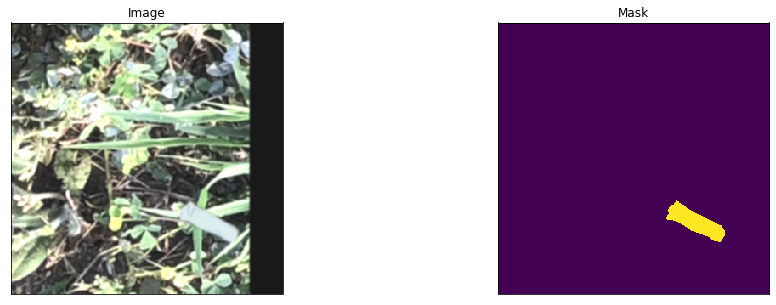

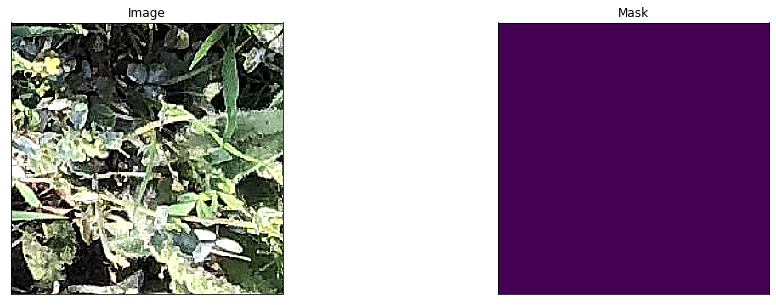

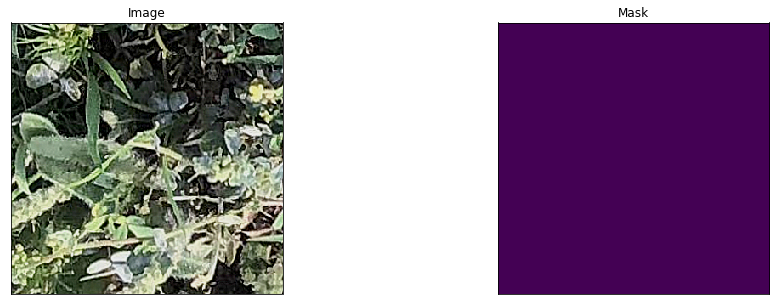

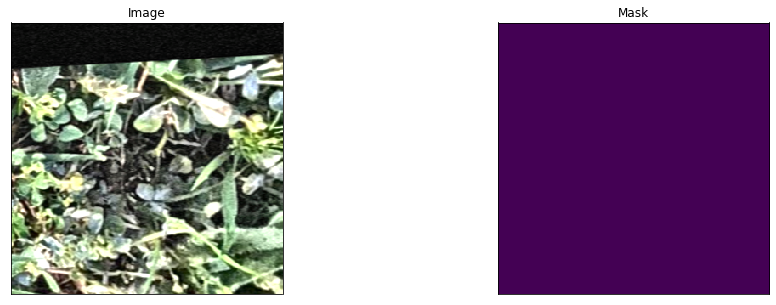

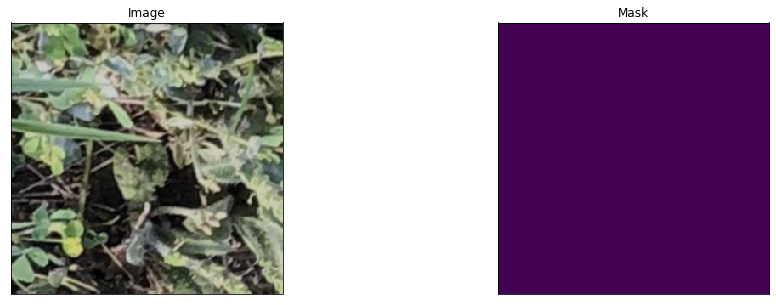

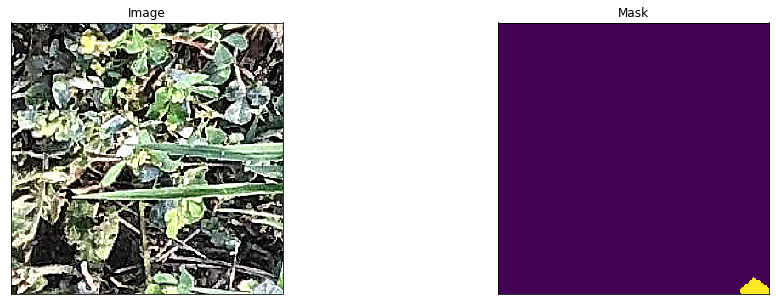

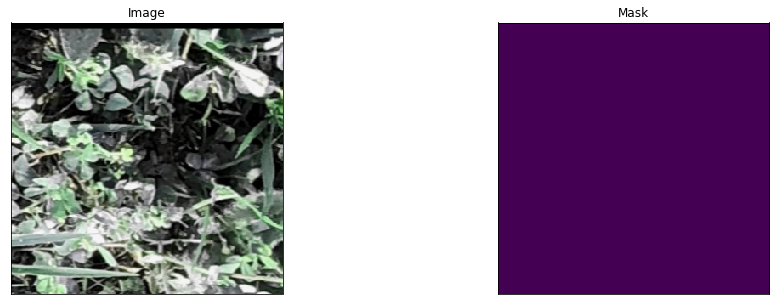

In [21]:
# Протестируем наши аугментации
augmented_dataset = Dataset(
    f"{path}/images", f"{path}/coco_annotations.json",
    augmentation=get_training_augmentation(),
)

# same image with different random transforms
for i in range(10):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze())

In [22]:
# Скачаем предобученную модель
ENCODER = 'efficientnet-b1'#efficientnet сейчас один из лучших классификаторов
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'
#Возьмем U-net саму популярную сеть на данный моемнт времени
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=None,
)


Downloading: "https://publicmodels.blob.core.windows.net/container/aa/efficientnet-b1-f1951068.pth" to /root/.cache/torch/checkpoints/efficientnet-b1-f1951068.pth


In [0]:
path_train = "data/train" 
path_mask_train = f"{path_train}/coco_annotations.json"
path_val = "data/val" 
path_mask_val = f"{path_val}/coco_annotations.json"

In [0]:
train_dataset = Dataset(
    path_train+'/images', 
    path_mask_train, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(),
)

valid_dataset = Dataset(
    path_val+'/images', 
    path_mask_val, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(),
)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)#батч размера один так как выпала урезанная GPU с cuda out of memory :(
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)#та же самая проблема

In [0]:
#так как DiceLoss давал плохие результаты берем JahardLoss

In [0]:
loss = smp.utils.losses.JaccardLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.7),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.001),
])

In [0]:

device = torch.device('cuda' if torch.cuda.is_available()  else 'cpu')

In [0]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [0]:
max_score = 0

for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 10:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 200/200 [00:11<00:00, 18.05it/s, jaccard_loss - 2.693, iou_score - 1.105]
Model saved!

Epoch: 1
valid: 100%|██████████| 200/200 [00:11<00:00, 18.09it/s, jaccard_loss - 3.555, iou_score - 1.322]
Model saved!

Epoch: 2
valid: 100%|██████████| 200/200 [00:11<00:00, 18.14it/s, jaccard_loss - 4.904, iou_score - 1.218]

Epoch: 3
valid: 100%|██████████| 200/200 [00:11<00:00, 18.16it/s, jaccard_loss - 52.7, iou_score - 1.17]

Epoch: 4
valid: 100%|██████████| 200/200 [00:11<00:00, 18.23it/s, jaccard_loss - 4.445, iou_score - 1.04]

Epoch: 5
valid: 100%|██████████| 200/200 [00:11<00:00, 18.05it/s, jaccard_loss - -0.4952, iou_score - 1.218]

Epoch: 6
valid: 100%|██████████| 200/200 [00:11<00:00, 18.01it/s, jaccard_loss - 4.134, iou_score - 1.1]

Epoch: 7
valid: 100%|██████████| 200/200 [00:11<00:00, 18.13it/s, jaccard_loss - 1.524, iou_score - 1.063]

Epoch: 8
valid: 100%|██████████| 200/200 [00:11<00:00, 17.84it/s, jaccard_loss - 6.641, iou_score - 1.171]

Epoc

In [0]:
# load best saved checkpoint
best_model = model

In [0]:
valid_dataset = Dataset(
    path_val+'/images', 
    path_mask_val, 
    # augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(),
)

test_dataloader = DataLoader(valid_dataset)

In [0]:
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 200/200 [00:11<00:00, 17.64it/s, jaccard_loss - 7.698, iou_score - 1.59]


In [0]:
test_dataset_vis = Dataset(
    path_val+'/images', 
    path_mask_val,
    preprocessing=get_preprocessing(),
    augmentation=get_validation_augmentation(), 

)

In [0]:
test_dataset_vis[0][0].shape

torch.Size([3, 512, 512])

Полученные результаты

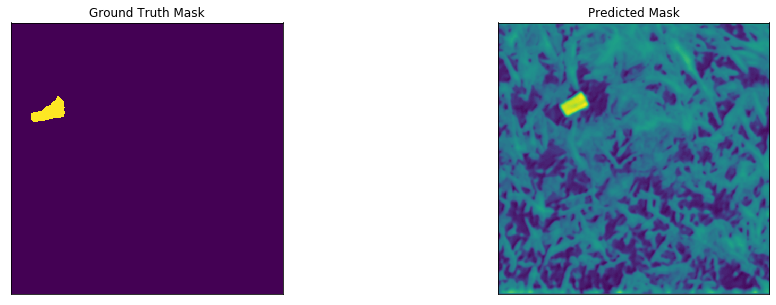

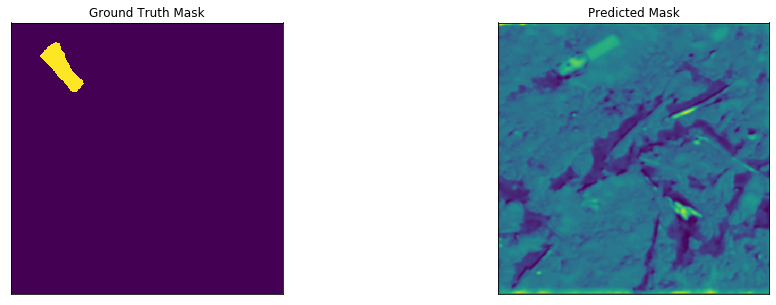

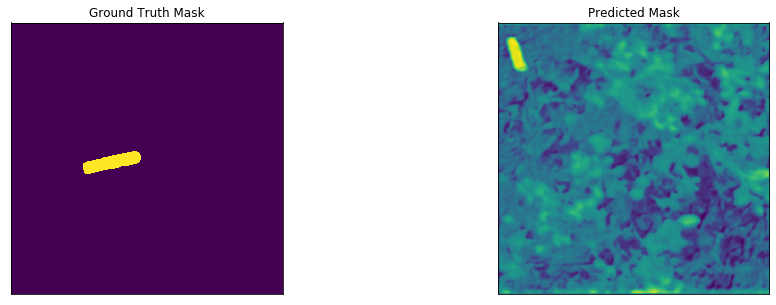

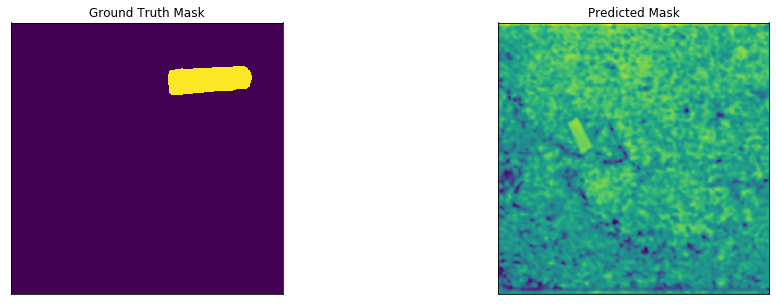

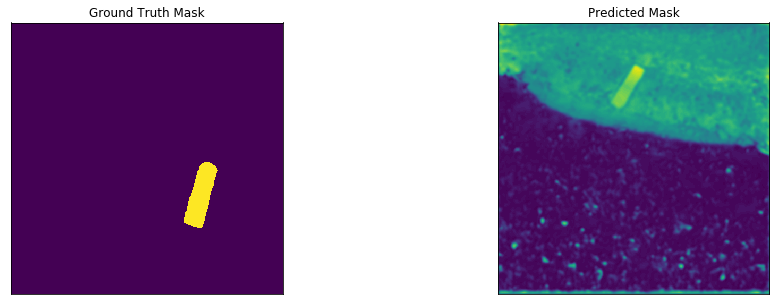

In [0]:
for i in range(5):
    n = np.random.choice(len(test_dataset_vis))
    
    image, gt_mask = test_dataset_vis[i]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().round())

    visualize(
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

[link text]Видно что иногда модель способна иногда находить нужные объекты, в целом модель не дообучилась. Надо считать было сильно больше. Также стоить отметить, что модель выучилась искать объекты в виде цилиндров, что значит что она поняла что окурки являются цилиндрами

Чтобы проверить что модель в целом учится и просто надо много времени, давайте посмотрим сможет ли она выучиться на одном объекте.

Модель берем ту же самую

In [29]:
max_score = 0
loss = smp.utils.losses.JaccardLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.001),
])
valid_loader = DataLoader([valid_dataset[0]], batch_size=1, shuffle=False)
for i in range(0, 100):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(valid_loader)


Epoch: 0
train: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s, jaccard_loss - 0.7913, iou_score - 0.2302]

Epoch: 1
train: 100%|██████████| 1/1 [00:00<00:00,  6.93it/s, jaccard_loss - -0.2557, iou_score - 0.6209]

Epoch: 2
train: 100%|██████████| 1/1 [00:00<00:00,  7.58it/s, jaccard_loss - -6.62, iou_score - 1.238]

Epoch: 3
train: 100%|██████████| 1/1 [00:00<00:00,  7.46it/s, jaccard_loss - 4.464, iou_score - 2.906]

Epoch: 4
train: 100%|██████████| 1/1 [00:00<00:00,  7.86it/s, jaccard_loss - 2.801, iou_score - 6.16]

Epoch: 5
train: 100%|██████████| 1/1 [00:00<00:00,  7.95it/s, jaccard_loss - 2.444, iou_score - 7.567]

Epoch: 6
train: 100%|██████████| 1/1 [00:00<00:00,  7.49it/s, jaccard_loss - 2.326, iou_score - 7.972]

Epoch: 7
train: 100%|██████████| 1/1 [00:00<00:00,  7.98it/s, jaccard_loss - 2.26, iou_score - 8.282]

Epoch: 8
train: 100%|██████████| 1/1 [00:00<00:00,  7.97it/s, jaccard_loss - 2.222, iou_score - 8.516]

Epoch: 9
train: 100%|██████████| 1/1 [00:00<00:00,  8.03it/s

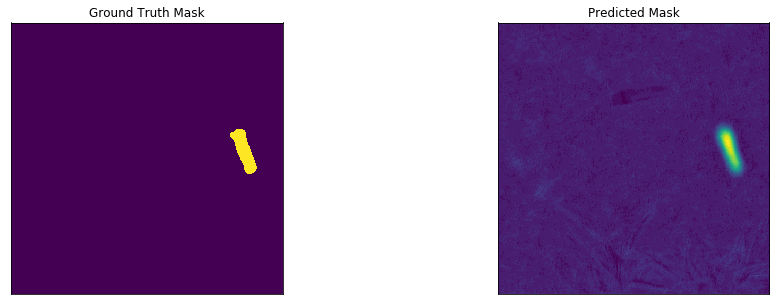

In [33]:
image, gt_mask = valid_dataset[0]
gt_mask = gt_mask.squeeze()
x_tensor = image.to(DEVICE).unsqueeze(0)
pr_mask = model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().round())

visualize(
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask)

Также в подтверждение наших слов посмотрим на DiceLoss  на том же одном объекте. Однако для этого прийдется заново создать модель, так как предыдущая что-то выучила:(

In [0]:
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=None,
)

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]


optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.001),
])

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)#батч размера один так как выпала урезанная GPU с cuda out of memoty :(
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)#та же самая проблема

In [37]:

for i in range(0, 100):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)



Epoch: 0
train: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, dice_loss - 0.3393, iou_score - 0.5403]

Epoch: 1
train: 100%|██████████| 1/1 [00:00<00:00,  7.43it/s, dice_loss - -0.3589, iou_score - 1.295]

Epoch: 2
train: 100%|██████████| 1/1 [00:00<00:00,  7.93it/s, dice_loss - -0.9122, iou_score - 2.129]

Epoch: 3
train: 100%|██████████| 1/1 [00:00<00:00,  7.71it/s, dice_loss - -1.836, iou_score - 2.914]

Epoch: 4
train: 100%|██████████| 1/1 [00:00<00:00,  7.45it/s, dice_loss - -5.035, iou_score - 3.688]

Epoch: 5
train: 100%|██████████| 1/1 [00:00<00:00,  7.38it/s, dice_loss - -10.28, iou_score - 4.097]

Epoch: 6
train: 100%|██████████| 1/1 [00:00<00:00,  7.68it/s, dice_loss - -13.35, iou_score - 4.796]

Epoch: 7
train: 100%|██████████| 1/1 [00:00<00:00,  7.33it/s, dice_loss - -19.1, iou_score - 5.798]

Epoch: 8
train: 100%|██████████| 1/1 [00:00<00:00,  7.90it/s, dice_loss - -24.06, iou_score - 6.953]

Epoch: 9
train: 100%|██████████| 1/1 [00:00<00:00,  7.87it/s, dice_loss - -27.5

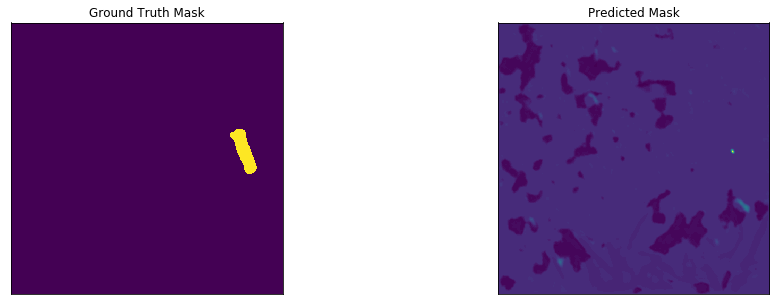

In [38]:
image, gt_mask = valid_dataset[0]
gt_mask = gt_mask.squeeze()
x_tensor = image.to(DEVICE).unsqueeze(0)
pr_mask = model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().round())

visualize(
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask)

Попробуем несколько эпох FPN

In [0]:
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=None,
)

loss = smp.utils.losses.JaccardLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]


optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.001),
])

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)


In [40]:
for i in range(0, 10):    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    


Epoch: 0
valid: 100%|██████████| 1/1 [00:00<00:00, 37.25it/s, jaccard_loss - 1.729, iou_score - 0.1599]

Epoch: 1
valid: 100%|██████████| 1/1 [00:00<00:00, 37.05it/s, jaccard_loss - 5.092, iou_score - 0.08083]

Epoch: 2
valid: 100%|██████████| 1/1 [00:00<00:00, 37.80it/s, jaccard_loss - 6.669, iou_score - 2.039]

Epoch: 3
valid: 100%|██████████| 1/1 [00:00<00:00, 37.71it/s, jaccard_loss - 4.514, iou_score - 2.07]

Epoch: 4
valid: 100%|██████████| 1/1 [00:00<00:00, 36.75it/s, jaccard_loss - 3.515, iou_score - 2.04]

Epoch: 5
valid: 100%|██████████| 1/1 [00:00<00:00, 25.28it/s, jaccard_loss - -5.295, iou_score - 3.017]

Epoch: 6
valid: 100%|██████████| 1/1 [00:00<00:00, 37.82it/s, jaccard_loss - 1.505, iou_score - 0.2088]

Epoch: 7
valid: 100%|██████████| 1/1 [00:00<00:00, 34.72it/s, jaccard_loss - 3.177, iou_score - 2.726]

Epoch: 8
valid: 100%|██████████| 1/1 [00:00<00:00, 37.11it/s, jaccard_loss - 0.2579, iou_score - 0.7084]

Epoch: 9
valid: 100%|██████████| 1/1 [00:00<00:00, 30.63it

In [0]:
path_val = "data/val" 

test_epoch = smp.utils.train.ValidEpoch(
    model=model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)


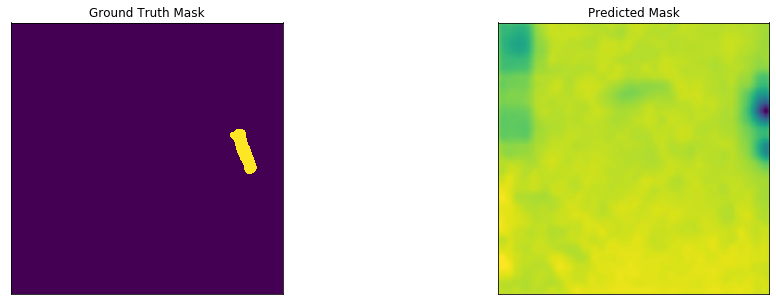

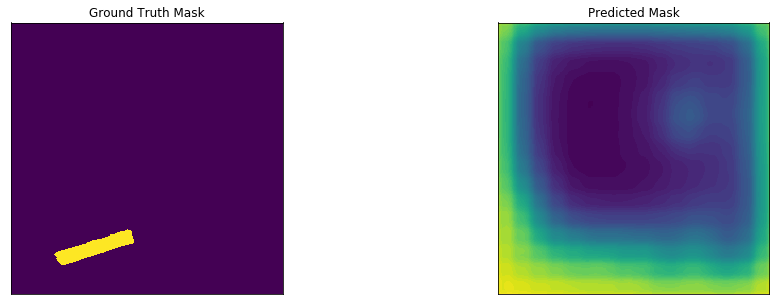

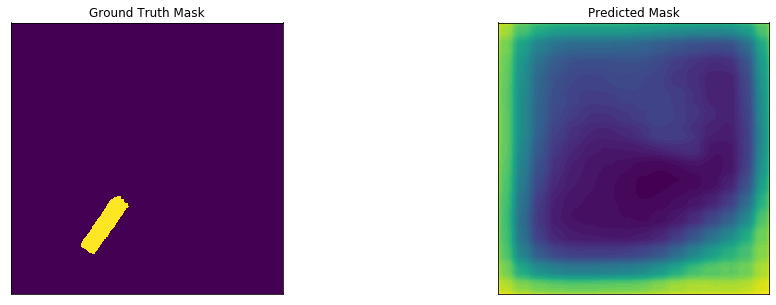

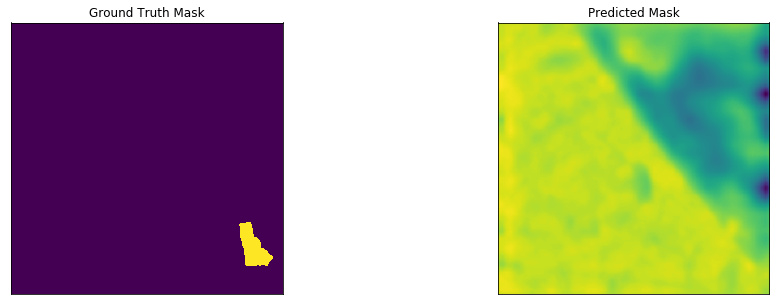

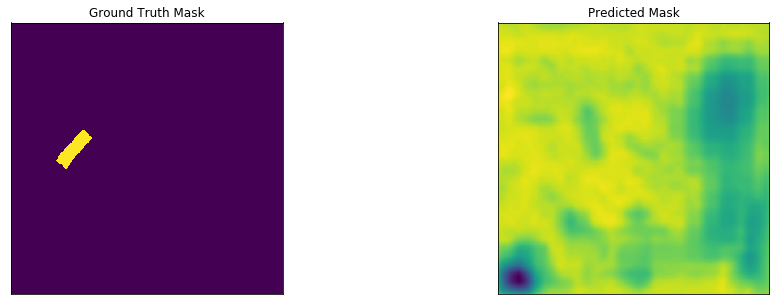

In [47]:
test_dataset_vis = Dataset(
    path_val+'/images', 
    path_mask_val,
    preprocessing=get_preprocessing(),
    augmentation=get_validation_augmentation(), 

)

for i in range(5):
    n = np.random.choice(len(test_dataset_vis))
    
    image, gt_mask = test_dataset_vis[i]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().round())

    visualize(
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )


Модель вообще необучилась, к сожалению нет еще времени, чтобы дообучить :(

В работе использовались и другие сети(например FCN) с различными encoder(Например MobilNetv2, Resnet,Densenet), однако они все не доучились имеем смысл прогнать их отдельно поставив считаться на несколько суток, однако нет столько GPU часов, и подходящего сервера. Для полного сравнения необходимы еще гпу часы. Необходимо считать несколько больше чем несколько часов надо сильно исхищраться или постоянно контролировать процесс обучения

В целом не сгенерировала файлик, так как качество недостатоно высокое, если бы была бы хотя бы еще одни выходные, чтобы сделать выбор на модели  и потом уже несколько часов ее гонять на колабе со всякими ухищрениями,то можно было бы рассчитывать на некоторый результат, а так и так видно, что есть